<a href="https://colab.research.google.com/github/changyuhsin1999/LLM_Item_Recommendation/blob/main/Baseline_collab_filtering_movie_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "LLM_Item_Recommendation" 
git_path = 'https://github.com/changyuhsin1999/LLM_Item_Recommendation.git'
!git clone "{git_path}"

Cloning into 'LLM_Item_Recommendation'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 2), reused 15 (delta 2), pack-reused 0
Receiving objects: 100% (19/19), 1.88 MiB | 4.47 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [23]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
raw_df = pd.read_csv('/content/LLM_Item_Recommendation/data/ml-latest-small/ratings.csv')
raw_df.drop(columns=['timestamp'],inplace=True)
raw_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [9]:
X = raw_df.loc[:,['userId','movieId']]
y = raw_df.loc[:,'rating']

# Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

In [10]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(),
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(),
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

In [11]:
class NNColabFiltering(nn.Module):

    def __init__(self, n_users, n_items, embedding_dim_users, embedding_dim_items, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embedding_dim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embedding_dim_items)
        self.fc1 = nn.Linear(embedding_dim_users+embedding_dim_items,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_items = self.item_embeddings(X[:,1])
        # Concatenate user and item embeddings
        embeddings = torch.cat([embedded_users,embedded_items],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds

In [12]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [16]:
# Train the model
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X.loc[:,'userId'].max()+1
n_items = X.loc[:,'movieId'].max()+1
model = NNColabFiltering(n_users,n_items,embedding_dim_users=50, embedding_dim_items=50, n_activations = 100,rating_range=[0.,5.])
criterion = nn.MSELoss()
lr=0.001
n_epochs=10
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)

Epoch 0/9
----------
train loss: 0.9726
val loss: 0.9521
Epoch 1/9
----------
train loss: 0.9154
val loss: 0.9096
Epoch 2/9
----------
train loss: 0.8759
val loss: 0.8841
Epoch 3/9
----------
train loss: 0.8547
val loss: 0.8730
Epoch 4/9
----------
train loss: 0.8391
val loss: 0.8639
Epoch 5/9
----------
train loss: 0.8283
val loss: 0.8622
Epoch 6/9
----------
train loss: 0.8182
val loss: 0.8598
Epoch 7/9
----------
train loss: 0.8102
val loss: 0.8601
Epoch 8/9
----------
train loss: 0.8035
val loss: 0.8618
Epoch 9/9
----------
train loss: 0.7994
val loss: 0.8612
Training complete in 1m 14s


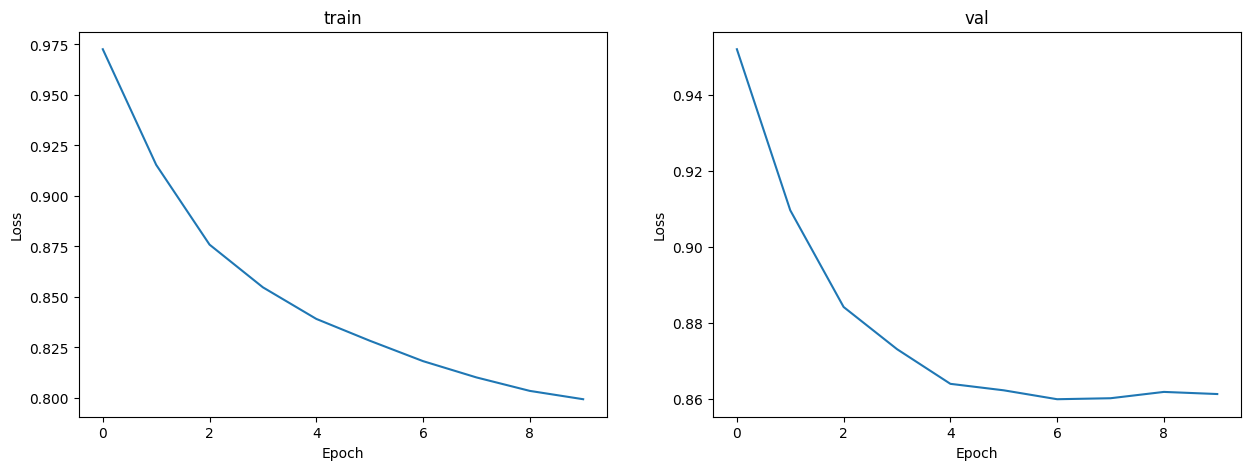

In [17]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

# Get predicted rating for a specific user-item pair from model

In [19]:
def predict_rating(model,userId,movieId, device):

    model = model.to(device)
    with torch.no_grad():
        model.eval()
        X = torch.Tensor([userId,movieId]).long().view(1,-1)
        X = X.to(device)
        pred = model.forward(X)
        return pred

# Get predicted rating for a random user-item pair
userId = 5
movieId = 10
print('User ID: {}'.format(userId))
print('Movie ID: {}'.format(movieId))
rating = predict_rating(model,userId,movieId,device)
print('Predicted rating is {:.1f}'.format(rating.detach().cpu().item()))

User ID: 5
Movie ID: 10
Predicted rating is 3.5


# Generate movie recommendation for the user

In [20]:
def generate_recommendations(movies,X,model,userId,device):
    # Get predicted ratings for every movie
    pred_ratings = []
    for movie in movies['movieId'].tolist():
        pred = predict_rating(model,userId,movie,device)
        pred_ratings.append(pred.detach().cpu().item())
    # Sort movies by predicted rating
    idxs = np.argsort(np.array(pred_ratings))[::-1]
    recs = movies.iloc[idxs]['movieId'].values.tolist()
    # Filter out movies already watched by user
    movies_watched = X.loc[X['userId']==userId, 'movieId'].tolist()
    recs = [rec for rec in recs if not rec in movies_watched]
    # Filter to top 10 recommendations
    recs = recs[:10]
    # Convert movieIDs to titles
    recs_names = []
    for rec in recs:
        recs_names.append(movies.loc[movies['movieId']==rec,'title'].values[0])
    return recs_names

In [22]:
# Get recommendations for a random user
userId = 5
movies = pd.read_csv("/content/LLM_Item_Recommendation/data/ml-latest-small/movies.csv")
recs = generate_recommendations(movies,X,model,userId,device)
for i,rec in enumerate(recs):
  print('Recommendation {}: {}'.format(i,rec))

Recommendation 0: Three Billboards Outside Ebbing, Missouri (2017)
Recommendation 1: One Flew Over the Cuckoo's Nest (1975)
Recommendation 2: Guess Who's Coming to Dinner (1967)
Recommendation 3: Fight Club (1999)
Recommendation 4: Rear Window (1954)
Recommendation 5: Casablanca (1942)
Recommendation 6: Star Wars: Episode IV - A New Hope (1977)
Recommendation 7: Dark Knight, The (2008)
Recommendation 8: Godfather, The (1972)
Recommendation 9: American History X (1998)
